# Simple Sequential Neural Network with Pytorch trained on Fruits-360 data

Credit for data:
* Horea Muresan, [Mihai Oltean](https://mihaioltean.github.io), [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning), Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.

In [213]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [214]:
# input constants
import os
import dotenv

dotenv.load_dotenv()
torch.manual_seed(42)

DATA_DIR = os.getenv('DATA_DIR')
training_data_dir = os.path.join(DATA_DIR, 'Training')
test_data_dir = os.path.join(DATA_DIR, 'Test')
partitions = os.listdir(training_data_dir)
VALIDATION_RATIO = float(os.getenv('VALIDATION_RATIO'))

BATCH_SIZE = int(os.getenv('BATCH_SIZE'))
LEARNING_RATE = float(os.getenv('LEARNING_RATE'))
EPOCHS= int(os.getenv('EPOCHS'))

MODEL_NAME = 'SSNN'

In [215]:
print(f"partitions ({len(partitions)} unique): {partitions}")
print(f"validation_ratio: {VALIDATION_RATIO}")
print(f"batch_size: {BATCH_SIZE}")
print(f"learning rate (lr): {LEARNING_RATE}")
print(f"epochs: {EPOCHS}")

partitions (131 unique): ['Apple Red Delicious', 'Apple Red 2', 'Cocos', 'Dates', 'Apple Red 1', 'Tangelo', 'Peach Flat', 'Pepper Green', 'Eggplant', 'Potato Red', 'Carambula', 'Mango Red', 'Pineapple', 'Pear 2', 'Huckleberry', 'Apple Red 3', 'Tomato 2', 'Grape Pink', 'Physalis', 'Tomato Yellow', 'Pear Forelle', 'Avocado ripe', 'Cactus fruit', 'Strawberry Wedge', 'Maracuja', 'Apple Pink Lady', 'Apple Red Yellow 2', 'Raspberry', 'Pitahaya Red', 'Avocado', 'Kiwi', 'Clementine', 'Pepino', 'Apple Crimson Snow', 'Lychee', 'Potato White', 'Onion Red', 'Kohlrabi', 'Apple Granny Smith', 'Potato Sweet', 'Grape White 3', 'Apricot', 'Chestnut', 'Nut Forest', 'Papaya', 'Pear Abate', 'Passion Fruit', 'Plum 2', 'Potato Red Washed', 'Cucumber Ripe 2', 'Cherry Wax Yellow', 'Pear Stone', 'Hazelnut', 'Apple Golden 2', 'Cantaloupe 2', 'Plum 3', 'Tomato 4', 'Tomato 1', 'Fig', 'Cherry 2', 'Cucumber Ripe', 'Lemon', 'Cherry Rainier', 'Corn', 'Rambutan', 'Pear Williams', 'Grape White 2', 'Banana Red', 'Apple 

# EDA

DATA_DIR listdir: ['test-multiple_fruits', 'readme.md', 'Training', 'Test', 'LICENSE', 'papers']


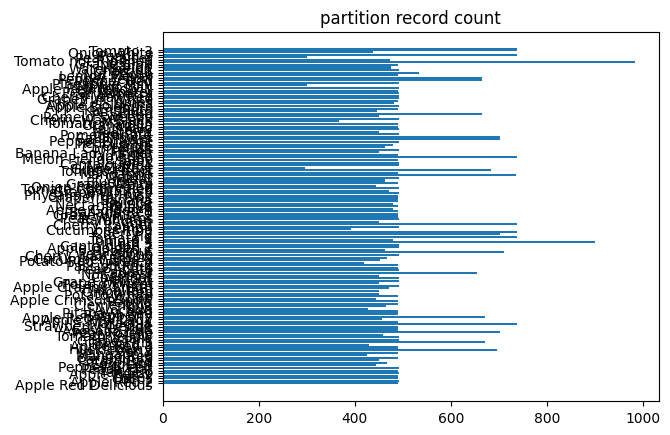

In [89]:
import matplotlib.pyplot as plt
# print data dir content
print(f"DATA_DIR listdir: {os.listdir(DATA_DIR)}")

# show partition frequency
counter = {}
for p in partitions:
    p_dir = os.path.join(training_data_dir, p)
    counter[p] = len(os.listdir(p_dir))

fig, ax = plt.subplots()
ax.barh(partitions, width=counter.values())
ax.set_title('partition record count')
plt.show()

# Data Ingestion

In [283]:
# trainin and validation data
dataset = datasets.ImageFolder(
    root=training_data_dir,
    transform=ToTensor()
)
classes = dataset.classes

valid_data_len = int(len(dataset) * VALIDATION_RATIO)
train_data_len = len(dataset) - valid_data_len
train_data, valid_data = torch.utils.data.random_split(
    dataset=dataset, 
    lengths=[train_data_len, valid_data_len]
)

# test data
test_data = datasets.ImageFolder(
    root=test_data_dir,
    transform=ToTensor()
)

In [192]:
print(f"len(train_and_valid_data): {len(dataset)}")
print(f"len(classes): {len(classes)}")
print(f"len(train_data): {len(train_data)} ({len(train_data)/len(dataset)*100:.4f}%)")
print(f"len(valid_data): {len(valid_data)} ({len(valid_data)/len(dataset)*100:.4f}%)")
print(f"len(test_data): {len(test_data)}")

len(train_and_valid_data): 67692
len(classes): 131
len(train_data): 57539 (85.0012%)
len(valid_data): 10153 (14.9988%)
len(test_data): 22688


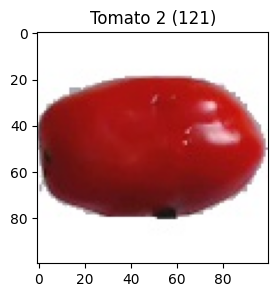

In [208]:
import matplotlib.pyplot as plt

def img_show_single(img, label):
    fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"{classes[label]} ({label})")
    
img_show_single(*train_data[1234])

In [284]:
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_data, 
    batch_size=BATCH_SIZE * 2,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_data, 
    batch_size=BATCH_SIZE * 2,
    shuffle=True,
    num_workers=2
)

In [210]:
# check shapes in first batch
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([100, 3, 100, 100])
Shape of y: torch.Size([100]) torch.int64


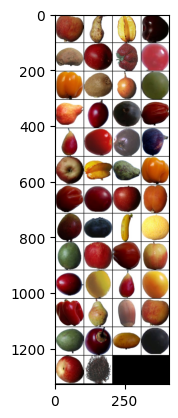

-------------  ------------------  ------------------  -----------------
Peach          Pear Abate          Carambula           Cherry 1
Potato Sweet   Nectarine           Strawberry Wedge    Redcurrant
Pepper Yellow  Kiwi                Granadilla          Grape White 4
Pear Red       Tamarillo           Plum 3              Tomato Heart
Pear 2         Tomato 4            Passion Fruit       Fig
Apple Red 3    Carambula           Pear Stone          Pepper Yellow
Tomato Heart   Cherry Wax Red      Apple Braeburn      Apricot
Mango Red      Blueberry           Banana Lady Finger  Cantaloupe 1
Mango          Apple Red Yellow 1  Tomato Heart        Apple Pink Lady
Tamarillo      Peach 2             Pear 2              Cherry Wax Yellow
Pepper Red     Pear Williams       Hazelnut            Peach
Mango          Tamarillo           Cucumber Ripe 2     Grape Blue
Nectarine      Rambutan
-------------  ------------------  ------------------  -----------------


In [275]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# function to show an image
def ing_show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a block of training data and labels
nb_in_row = 4
xb, yb = next(iter(train_loader))
grid = torchvision.utils.make_grid(
    tensor=xb, 
    nrow=nb_in_row
)

# show images
ing_show_grid(grid)

# print labels
k, m = divmod(len(yb), nb_in_row) 
yb_lists = [yb[i*nb_in_row : min((i+1)*nb_in_row, len(yb))] for i in range(k+1)]
label_lists = [[classes[y] for y in yb_list] for yb_list in yb_lists]
print(tabulate(label_lists))

# Device definition

In [216]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [217]:
class DeviceDataLoader():
    """
    DataLoader wrapper to move data to a device
    """
    
    @classmethod
    def __to_device(cls, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [cls.__to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield self.__to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [285]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Model Configuration

## Classification model utilities

In [235]:
def accuracy(
    pred: torch.Tensor, 
    labels: torch.Tensor
) -> float:
    """
    Custom accuracy metric
    """
    _, preds = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [247]:
from typing import List, Dict


class ClassificationBase(nn.Module):
    """
    Base class for multilabel classification models
    """    
    def training_step(self, batch: List[torch.Tensor]) -> float:
        X, y = batch
        
        # Compute prediction error
        pred = model(X)
        loss = self._loss_fn(pred, y)
        
        return loss
    
    def validation_step(self, batch: List[torch.Tensor]) -> Dict:
        X, y = batch
        
        # Compute prediction error
        pred = model(X)
        loss = self._loss_fn(pred, y)
        
        # Compute accuracy
        acc = self._accuracy_fn(pred, y)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs: Dict) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch: int, result: Dict) -> str:
        print(f"Epoch [{epoch}], \
              train_loss: {result['train_loss']:.4f}, \
              val_loss: {result['val_loss']:.4f}, \
              val_acc: {result['val_acc']:.4f}"
        )

In [251]:
from tqdm import tqdm
from typing import List, Dict


def evaluate(
    model: nn.Module, 
    valid_loader: DataLoader
) -> str:
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)


def fit(
    epochs: int, 
    lr: float, 
    model: nn.Module, 
    train_loader: DataLoader, 
    valid_loader: DataLoader, 
    opt_func: callable = torch.optim.SGD
) -> List[Dict]:
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Input data specific configuration

In [238]:
import random
rnd_index = random.randint(0, len(train_data))
rnd_tensor, rnd_label = train_data[rnd_index]
rnd_tensor_flat = nn.Flatten(0,-1)(rnd_tensor) 
input_dim = list(rnd_tensor_flat.size())[0]
print(f"input_dim: {input_dim}")

input_dim: 30000


In [239]:
class SimpleSequentialNetwork(ClassificationBase):
    
    def __init__(self, input_dim, output_dim, loss_fn, accuracy_fn):
        super().__init__()
        self._loss_fn = loss_fn
        self._accuracy_fn = accuracy_fn
        self._flatten = nn.Flatten()
        self._linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),  # input layer
            nn.ReLU(),
            nn.Linear(512, 256),  # hidden layer
            nn.ReLU(),
            nn.Linear(256, output_dim)  # output layer
        )
        
    def forward(self, xb):
        # flatten batch of x (xb) into vectors
        x = self._flatten(xb)
        # apply layers & activation functions
        logits = self._linear_relu_stack(x)
        return logits
    
    
model = SimpleSequentialNetwork(
    input_dim=input_dim,
    output_dim=len(classes),
    loss_fn=nn.CrossEntropyLoss(),
    accuracy_fn=accuracy
)
model = model.to(device)
print(model)

SimpleSequentialNetwork(
  (_loss_fn): CrossEntropyLoss()
  (_flatten): Flatten(start_dim=1, end_dim=-1)
  (_linear_relu_stack): Sequential(
    (0): Linear(in_features=30000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=131, bias=True)
  )
)


# Training job

In [240]:
# performance before training
history = [evaluate(model, valid_loader)]
history

[{'val_loss': 4.877549171447754, 'val_acc': 0.009313724935054779}]

In [252]:
# training model
model.train()
history += fit(
    model=model,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    train_loader=train_loader,
    valid_loader=valid_loader,
    opt_func=torch.optim.SGD
)
# optionally call fit() multiple times with different epochs and lr values

  0%|          | 0/1151 [00:00<?, ?it/s]           

Epoch [0], train_loss: 4.7404, val_loss: 4.5728, val_acc: 0.0520


  0%|          | 0/1151 [00:00<?, ?it/s]           

Epoch [1], train_loss: 4.2320, val_loss: 3.8036, val_acc: 0.1954


Exception ignored in:                              <function _MultiProcessingDataLoaderIter.__del__ at 0x7649d02cf490>
Traceback (most recent call last):
  File "/home/a/workspace/icook/icook_recogniser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/a/workspace/icook/icook_recogniser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7649d02cf490>
Traceback (most recent call last):
  File "/home/a/workspace/icook/icook_recogniser/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/

Epoch [2], train_loss: 3.3046, val_loss: 2.8371, val_acc: 0.3964


  0%|          | 0/1151 [00:00<?, ?it/s]           

Epoch [3], train_loss: 2.4581, val_loss: 2.1150, val_acc: 0.5302


Epoch [4], train_loss: 1.8621, val_loss: 1.6229, val_acc: 0.6675


# Evaluations

In [276]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

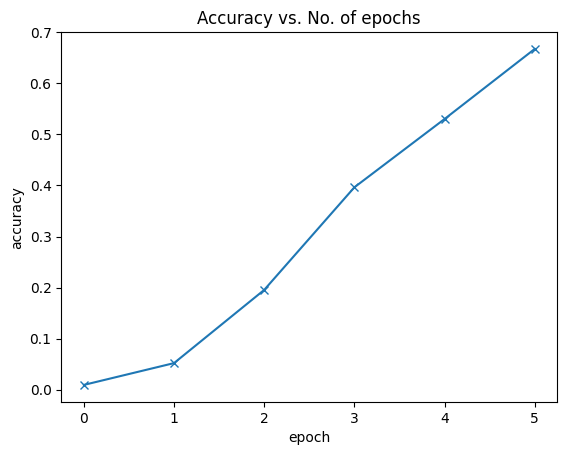

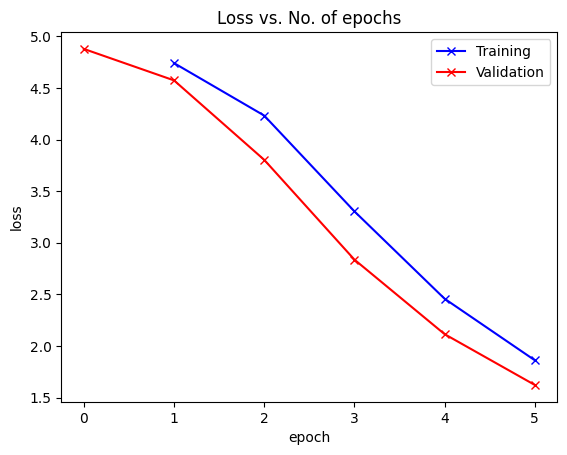

In [278]:
plot_accuracies(history)
plot_losses(history)

In [279]:
model.eval()
evaluate(model, test_loader)

{'val_loss': 1.9861299991607666, 'val_acc': 0.5588045716285706}

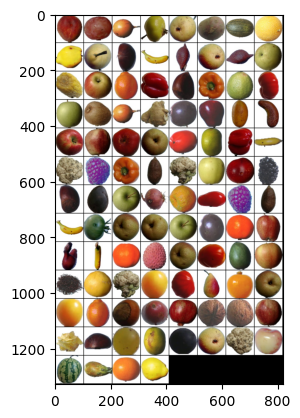

Ground truth
------------------  ------------------  ------------------  ------------------  ------------------  -------------------  ------------------  --------------
Peach               Grape Pink          Granadilla          Apple Red Yellow 2  Pear 2              Potato Red           Melon Piel de Sapo  Cantaloupe 1
Quince              Pear 2              Chestnut            Banana Lady Finger  Salak               Pear 2               Salak               Apple Golden 3
Corn                Apple Red 2         Tangelo             Pepper Red          Chestnut            Pepper Orange        Limes               Tomato 3
Apple Granny Smith  Kiwi                Granadilla          Ginger Root         Passion Fruit       Apple Red Delicious  Cucumber Ripe 2     Cucumber Ripe
Apple Crimson Snow  Apple Red 3         Nectarine Flat      Pear Forelle        Kaki                Pomelo Sweetie       Pepper Red          Banana
Cauliflower         Raspberry           Pepper Orange       Nut Peca

In [311]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# get a block of test data and labels
nb_in_row = 8
xb, yb = next(iter(test_loader))
grid = torchvision.utils.make_grid(
    tensor=xb, 
    nrow=nb_in_row
)

# show images
ing_show_grid(grid)

# print labels
k, m = divmod(len(yb), nb_in_row) 
yb_lists = [yb[i*nb_in_row : min((i+1)*nb_in_row, len(yb))] for i in range(k+1)]
ground_label_lists = [[classes[y] for y in yb_list] for yb_list in yb_lists]
print("Ground truth")
print(tabulate(ground_label_lists))

In [317]:
# prediction
logits = model(xb)
_, predicted = torch.max(logits, 1)
predicted_label_lists = [classes[y_hat] for y_hat in predicted]

ground_label_lists = [classes[y] for y in yb]
comparison = [['Match', 'Ground truth', 'Predicted'],['-'*5,'-'*10,'-'*10]]
for (gt, pred) in zip(ground_label_lists, predicted_label_lists):
    comparison.append([True if gt == pred else '', gt, pred])

print(tabulate(comparison))

-----  -------------------  -------------------
Match  Ground truth         Predicted
-----  ----------           ----------
       Peach                Grape Pink
       Grape Pink           Cherry 2
       Granadilla           Pear 2
       Apple Red Yellow 2   Cucumber Ripe 2
       Pear 2               Peach 2
       Potato Red           Pear Forelle
True   Melon Piel de Sapo   Melon Piel de Sapo
True   Cantaloupe 1         Cantaloupe 1
True   Quince               Quince
       Pear 2               Onion White
       Chestnut             Rambutan
True   Banana Lady Finger   Banana Lady Finger
True   Salak                Salak
       Pear 2               Peach 2
       Salak                Eggplant
True   Apple Golden 3       Apple Golden 3
       Corn                 Peach 2
True   Apple Red 2          Apple Red 2
       Tangelo              Kaki
True   Pepper Red           Pepper Red
       Chestnut             Blueberry
True   Pepper Orange        Pepper Orange
True   Limes      

In [318]:
torch.save(model.state_dict(), f"{MODEL_NAME}.pth")
print(f"Saved model {MODEL_NAME}.pth")

Saved model SSNN.pth
